In [1]:
####################
# Should you be taking the phase difference at each frequency? You would have to interpolate.
# Which is better?
# ***Or should you be using the same frequency TimeSeries for each curve? So that
# there is the same 1--1 relation between t and f for each curve. 
####################

In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Modules for generating waveforms
import lalsimulation # Get waveform functions
import lal # Get constants
import pycbc.types # TimeSeries
import pycbc.waveform # Waveforms

In [3]:
lal.G_SI, lal.C_SI, 1.0e6*lal.PC_SI, lal.MSUN_SI

(6.67384e-11, 299792458.0, 3.085677581491367e+22, 1.9885469549614615e+30)

In [4]:
# Use the exact same units as LAL
G_SI = 6.67384e-11
C_SI = 299792458.0
MPC_SI = 3.085677581491367e+22
MSUN_SI = 1.9885469549614615e+30

In [5]:
# Versions of HDF5 earlier than 1.8.13 seem to give trouble
import h5py
print h5py.version.info

Summary of the h5py configuration
---------------------------------

h5py    2.5.0
HDF5    1.8.14
Python  2.7.10 (default, Sep 24 2015, 00:07:46) 
[GCC 4.4.5 20110214 (Red Hat 4.4.5-6)]
sys.platform    linux2
sys.maxsize     9223372036854775807
numpy   1.10.1



In [6]:
sys.path.insert(0, '../cbcrom')

import timedomainwaveform as tdwave
import timedomainrom as tdrom
import eobtrainingset as eob
import greedy
import empiricalinterpolation as eim
import diagnostics as diagnostics
import chebyshev as cheb
import timeseriesutils as tsutils

import imp
imp.reload(tdwave)
imp.reload(tdrom)
imp.reload(eob)
imp.reload(greedy)
imp.reload(eim)
imp.reload(diagnostics)
imp.reload(cheb)
imp.reload(tsutils)

<module 'timeseriesutils' from '../cbcrom/timeseriesutils.pyc'>

In [7]:
pyplot.rcParams.update({
    'figure.figsize': (8, 6),    # figure size in inches
    'text.usetex': True,
#     "font.family": 'serif',
#     "font.serif": ['Computer Modern'],
    'font.size': 14,
    #'axes.titlesize': 20,
    'axes.labelsize': 20,
    'axes.linewidth': 2,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 14,
    'xtick.major.size': 8,
    'xtick.minor.size': 4, 
    'xtick.major.width': 2,
    'xtick.minor.width': 2,
    'xtick.direction': 'out',
    'ytick.major.size': 8,
    'ytick.minor.size': 4, 
    'ytick.major.width': 2,
    'ytick.minor.width': 2,
    'ytick.direction': 'out',  
    'axes.prop_cycle'    : cycler('color', 'bgrcmyk'),
    })

# Load ROM

In [8]:
memb_size=2**26-1

# Bamp_filename = '../data/Bamp_cheb_3_%d.hdf5'
# Bphase_filename = '../data/Bphase_cheb_3_%d.hdf5'
# ampcoeff_filename = '../data/amp_coeffs_cheb_3.hdf5'
# phasecoeff_filename = '../data/phase_coeffs_cheb_3.hdf5'

# Bamp_filename = '../data/Bamp_cheb_9_%d.hdf5'
# Bphase_filename = '../data/Bphase_cheb_9_%d.hdf5'
# ampcoeff_filename = '../data/amp_coeffs_cheb_9.hdf5'
# phasecoeff_filename = '../data/phase_coeffs_cheb_9.hdf5'

Bamp_filename = '../data/Bamp_cheb_16_%d.hdf5'
Bphase_filename = '../data/Bphase_cheb_16_%d.hdf5'
ampcoeff_filename = '../data/amp_coeffs_cheb_16.hdf5'
phasecoeff_filename = '../data/phase_coeffs_cheb_16.hdf5'

rom = tdrom.load_reduced_order_model_time_domain_waveform(Bamp_filename, Bphase_filename, memb_size,
                                                  ampcoeff_filename, phasecoeff_filename)

In [9]:
def reduced_order_model_time_series(rom, **kwargs):
    """Convert to pycbc TimeSeries.
    """
    tstart, delta_t, hp, hc = rom.evaluate_physical_units(**kwargs)
    hplus = pycbc.types.TimeSeries(hp, epoch=tstart, delta_t=delta_t)
    hcross = pycbc.types.TimeSeries(hc, epoch=tstart, delta_t=delta_t)
    return hplus, hcross

# Functions for comparing waveforms

In [10]:
def time_series_from_eob_file(filename, mass1=None, mass2=None, delta_t=None, distance=None, inclination=None, f_lower=None):
    """
    """
    
    time, amp, phase = eob.time_amp_phase_from_filename(filename)
    h22 = tdwave.TimeDomainWaveform(time, amp, phase)
    
    # Remove points at the end where the phase is decreasing.
    h22.remove_decreasing_phase()
    # For some reason, the initial sampling does not give monotonic frequency
    # So resample uniform in phase
    h22.resample_uniform_in_phase(samples_per_cycle=5.0)
    
    # Get times in seconds
    mtot = (mass1+mass2)*MSUN_SI
    time_phys = h22.time*G_SI*mtot/C_SI**3
    eta = mass1*mass2/(mass1+mass2)**2
    
    # Regge-Zerilli --> spin weighted
    ell = 2
    znorm = eta*np.sqrt((ell+2)*(ell+1)*ell*(ell-1))
    h22.amp *= znorm
    
    # Interpolate amplitude and phase
    order = 3
    ampoft = scipy.interpolate.UnivariateSpline(time_phys, h22.amp, k=order, s=0)
    phaseoft = scipy.interpolate.UnivariateSpline(time_phys, h22.phase, k=order, s=0)
    omegaoft = phaseoft.derivative(n=1)
    freq = omegaoft(time_phys)/(2*np.pi)
    #print freq
    #print np.max(freq)

    # Find region where frequency is monotonically increasing, then construct t(f)
    i_end_mono = next( (i for i in range(len(freq)-1) if freq[i]>=freq[i+1]), (len(freq)-1) )
    #print freq[0], freq[i_end_mono]
    toffreq = scipy.interpolate.UnivariateSpline(freq[:i_end_mono], time_phys[:i_end_mono], k=order, s=0)
    
    # Resample with even spacing
    tstart = toffreq([f_lower])[0]

    #tstart = time_phys[0]
    time_phys_res = np.arange(tstart, time_phys[-1], delta_t)
    amp_res = ampoft(time_phys_res)
    phase_res = phaseoft(time_phys_res)
    # Zero the phase at the beginning
    phase_res -= phase_res[0]
    
    # Rescale amplitude
    h22_to_h = np.sqrt(5.0/np.pi)/2.0
    amp_units = G_SI*mtot/(C_SI**2*distance*MPC_SI)
    amp_rescale = amp_units*h22_to_h*amp_res

    # Adjust for inclination angle [0, pi]
    inc_plus = (1.0+np.cos(inclination)**2)/2.0
    inc_cross = np.cos(inclination)
    
    hplus = inc_plus*amp_rescale*np.cos(phase_res)
    hcross = inc_cross*amp_rescale*np.sin(phase_res)
    
    hplus = pycbc.types.TimeSeries(hplus, epoch=tstart, delta_t=delta_t)
    hcross = pycbc.types.TimeSeries(hcross, epoch=tstart, delta_t=delta_t)
    return hplus, hcross

In [11]:
def frequency_from_complex(hcomplex):
    """
    """
    phase = tsutils.phase_from_complex_time_series(hcomplex)
    times = np.array(phase.sample_times.numpy())

    # Interpolate phase
    order = 3
    phaseoft = scipy.interpolate.UnivariateSpline(times, np.array(phase.numpy()), k=order, s=0)
    omegaoft = phaseoft.derivative(n=1)
    freq = omegaoft(times)/(2*np.pi) 
    
    return pycbc.types.TimeSeries(freq, delta_t=phase.delta_t, epoch=phase.start_time)

In [12]:
def phase_difference(hp1, hc1, hp2, hc2, endpoint=None):
    """Evaluate phase1 - phase2.
    """
    delta_t = hp1.delta_t
    
    h1complex = tsutils.polarizations_to_complex(hp1, hc1)
    h2complex = tsutils.polarizations_to_complex(hp2, hc2)
    amp1, phase1 = tsutils.amp_phase_from_complex(h1complex, remove_start_phase=True)
    amp2, phase2 = tsutils.amp_phase_from_complex(h2complex, remove_start_phase=True)
    
    # The last index of the shortest waveform
    endi = min(len(phase1)-1, len(phase2)-1)
    phasediff = phase1.numpy()[:endi+1] - phase2.numpy()[:endi+1]
    print endi
    # put adjustments due to optional arguments here
    if endpoint == 'maxamp':
        # Index of the max amplitude
        maxamp1, maxampi1 = amp1.abs_max_loc()
        maxamp2, maxampi2 = amp2.abs_max_loc()
        endi = min(endi, maxampi1, maxampi2)
        print maxampi1, maxampi2, endi
        return pycbc.types.TimeSeries(phasediff[:endi+1], delta_t=delta_t)
    else:
        return pycbc.types.TimeSeries(phasediff, delta_t=delta_t)

# Compare Sebastiano's EOB waveforms

In [13]:
# k3=0, k4=0 Using EOS not fit
# k4=0 Using EOS not fit
# correct Using EOS not fit
# correct, but k3 shifted by 10% and k4 shifted by 15%
# filename_list = [
#     'sly135135_k30_k40.h5', 
#     'sly135135_k40.h5',
#     'sly135135.h5',
#     'sly135135_k3p10_k4p15.h5',
#     'ms1b135135_k30_k40.h5', 
#     'ms1b135135_k40.h5', 
#     'ms1b135135.h5', 
#     'ms1b135135_k3p05_k4p10.h5',
#     'bbh135135.h5',
#     'bbh_q1_DNB12.h5', 
#     'bbh_q1_NDRP15.h5'
# ]

filename_list = [
    '../comparison_waveforms/sly140140_k3k40.h5', 
    '../comparison_waveforms/sly140140_k40.h5', 
    '../comparison_waveforms/sly140140_target.h5', 
    '../comparison_waveforms/sly140140_fit.h5', 
    '../comparison_waveforms/ms1b140140_k3k40.h5', 
    '../comparison_waveforms/ms1b140140_k40.h5', 
    '../comparison_waveforms/ms1b140140_target.h5', 
    '../comparison_waveforms/ms1b140140_fit.h5', 
    '../comparison_waveforms/bbh135135.h5', 
    '../comparison_waveforms/bbh_q1_DNB12.h5', 
    '../comparison_waveforms/bbh_q1_NDRP15.h5'
]


f_sample = 2**14
f_lower = 30
waveform_list = []
for i in range(len(filename_list)):
    filename = filename_list[i]
    print filename
    
    hp, hc = time_series_from_eob_file(filename, mass1=1.35, mass2=1.35, 
                                   delta_t=1.0/f_sample, distance=100, inclination=0.0, f_lower=f_lower)
    
    hp.start_time, hc.start_time = 0.0, 0.0
    hcomplex = tsutils.polarizations_to_complex(hp, hc)
    amp, phase = tsutils.amp_phase_from_complex(hcomplex, remove_start_phase=True)
    freq = frequency_from_complex(hcomplex)
    waveform_list.append({'label': filename, 'hp': hp, 'hc': hc, 'amp': amp, 'phase': phase, 'freq': freq})

../comparison_waveforms/sly140140_k3k40.h5
../comparison_waveforms/sly140140_k40.h5
../comparison_waveforms/sly140140_target.h5
../comparison_waveforms/sly140140_fit.h5
../comparison_waveforms/ms1b140140_k3k40.h5
../comparison_waveforms/ms1b140140_k40.h5
../comparison_waveforms/ms1b140140_target.h5
../comparison_waveforms/ms1b140140_fit.h5
../comparison_waveforms/bbh135135.h5
../comparison_waveforms/bbh_q1_DNB12.h5
../comparison_waveforms/bbh_q1_NDRP15.h5


In [14]:
i=0
hp = waveform_list[i]['hp']
hc = waveform_list[i]['hc']

In [15]:
np.array(hcomplex), np.array(hcomplex.sample_times)

(array([  1.47433416e-23 +0.00000000e+00j,
          1.47423697e-23 +1.69616357e-25j,
          1.47394465e-23 +3.39210418e-25j, ...,
          2.15108648e-22 -2.36426160e-22j,
          2.05057112e-22 +2.39271493e-22j,  -1.77343458e-22 +6.16686479e-23j]),
 array([  0.00000000e+00,   6.10351562e-05,   1.22070312e-04, ...,
          5.80172119e+01,   5.80172729e+01,   5.80173340e+01]))

In [16]:
def polarizations_to_time_domain_waveform(hp, hc):
    """
    """
    hcomplex = tsutils.polarizations_to_complex(hp, hc)
    h = tdwave.complex_to_time_domain_waveform(np.array(hcomplex.sample_times), np.array(hcomplex))
    return h

In [17]:
i=0
hp = waveform_list[i]['hp']
hc = waveform_list[i]['hc']
h1 = polarizations_to_time_domain_waveform(hp, hc)

i=1
hp = waveform_list[i]['hp']
hc = waveform_list[i]['hc']
h2 = polarizations_to_time_domain_waveform(hp, hc)

In [18]:
h1.time

array([  0.00000000e+00,   6.10351562e-05,   1.22070312e-04, ...,
         5.80146484e+01,   5.80147095e+01,   5.80147705e+01])

In [19]:
def resample_waveforms_to_match_start_end_times(h1, h2, samples_per_cycle=100.0):
    """Resample h1 and h2 so they have the same time samples.
    This function assumes that t=0 corresponds to the maximum amplitude.
    
    Parameters
    ----------
    h1 : TimeDomainWaveform
    h2 : TimeDomainWaveform
    samples_per_cycle : float, 100
    
    Returns
    -------
    h1_new : TimeDomainWaveform
    h2_new : TimeDomainWaveform
    """
    # Copy the waveforms so you don't overwrite them.
    h1_new = h1.copy()
    h2_new = h2.copy()
    
    # Get new start and end times that are common to both waveforms
    t_start = max(h1_new.time[0], h2_new.time[0])
    t_end = min(h1_new.time[-1], h2_new.time[-1])
    
    # Get new time samples from the interval of h1 that also belongs to h2
    t = h1.time
    t_new = np.array([t[i] for i in range(len(t)) if t[i]>t_start and t[i]<t_end])
    
    # Sample evenly in phase
    h1_new.resample_at_times(t_new)
    h1_new.resample_uniform_in_phase(samples_per_cycle=samples_per_cycle)
    h2_new.resample_at_times(t_new)
    
    # Shift phase to be 0 at beginning for both
    h1_new.phase_shift(remove_start_phase=True)
    h2_new.phase_shift(remove_start_phase=True)
    
    return h1_new, h2_new

In [20]:
h1_new, h2_new = resample_waveforms_to_match_start_end_times(h1, h2, samples_per_cycle=10.0)

In [21]:
len(h1.time), len(h1_new.time)

(950515, 27756)

In [22]:
def phase_difference_of_frequency(hp1, hc1, hp2, hc2, endpoint=None):
    """Evaluate phase1 - phase2.
    """
    delta_t = hp1.delta_t
    
    h1complex = tsutils.polarizations_to_complex(hp1, hc1)
    h2complex = tsutils.polarizations_to_complex(hp2, hc2)
    amp1, phase1 = tsutils.amp_phase_from_complex(h1complex, remove_start_phase=True)
    amp2, phase2 = tsutils.amp_phase_from_complex(h2complex, remove_start_phase=True)
    
    # The last index of the shortest waveform
    endi = min(len(phase1)-1, len(phase2)-1)
    phasediff = phase1.numpy()[:endi+1] - phase2.numpy()[:endi+1]
    print endi
    # put adjustments due to optional arguments here
    if endpoint == 'maxamp':
        # Index of the max amplitude
        maxamp1, maxampi1 = amp1.abs_max_loc()
        maxamp2, maxampi2 = amp2.abs_max_loc()
        endi = min(endi, maxampi1, maxampi2)
        print maxampi1, maxampi2, endi
        return pycbc.types.TimeSeries(phasediff[:endi+1], delta_t=delta_t)
    else:
        return pycbc.types.TimeSeries(phasediff, delta_t=delta_t)

In [23]:
################### Bernuzzi's BBH waveforms ####################

# Same as BNS case (no NQC corrections) and really small values of tidal parameters
bbh_nqc0 = waveform_list[8]
# Bernuzzi's Matlab code with NQC corrections turned on and no tidal parameters
bbh_dnb = waveform_list[9]
# Nagar's newest tunings for BBH and no tidal parameters
bbh_ndr = waveform_list[10]


nqc0effect = phase_difference(bbh_nqc0['hp'], bbh_nqc0['hc'], bbh_ndr['hp'], bbh_ndr['hc'])
dnbeffect = phase_difference(bbh_dnb['hp'], bbh_dnb['hc'], bbh_ndr['hp'], bbh_ndr['hc'])


################### BNS waveforms ######################

sly2 = waveform_list[0]
sly23 = waveform_list[1]
sly234 = waveform_list[2]
sly234fit = waveform_list[3]

slyeffect = phase_difference(sly234['hp'], sly234['hc'], bbh_ndr['hp'], bbh_ndr['hc'])
sly2effect = phase_difference(sly2['hp'], sly2['hc'], bbh_ndr['hp'], bbh_ndr['hc'])
sly3effect = phase_difference(sly23['hp'], sly23['hc'], sly2['hp'], sly2['hc'])
sly4effect = phase_difference(sly234['hp'], sly234['hc'], sly23['hp'], sly23['hc'])
slyfiteffect = phase_difference(sly234fit['hp'], sly234fit['hc'], sly234['hp'], sly234['hc'])


ms1b2 = waveform_list[4]
ms1b23 = waveform_list[5]
ms1b234 = waveform_list[6]
ms1b234fit = waveform_list[7]

ms1beffect = phase_difference(ms1b234['hp'], ms1b234['hc'], bbh_ndr['hp'], bbh_ndr['hc'])
ms1b2effect = phase_difference(ms1b2['hp'], ms1b2['hc'], bbh_ndr['hp'], bbh_ndr['hc'])
ms1b3effect = phase_difference(ms1b23['hp'], ms1b23['hc'], ms1b2['hp'], ms1b2['hc'])
ms1b4effect = phase_difference(ms1b234['hp'], ms1b234['hc'], ms1b23['hp'], ms1b23['hc'])
ms1bfiteffect = phase_difference(ms1b234fit['hp'], ms1b234fit['hc'], ms1b234['hp'], ms1b234['hc'])

950549
950556
950512
950514
950512
950512
950512
950435
950439
950435
950435
950435


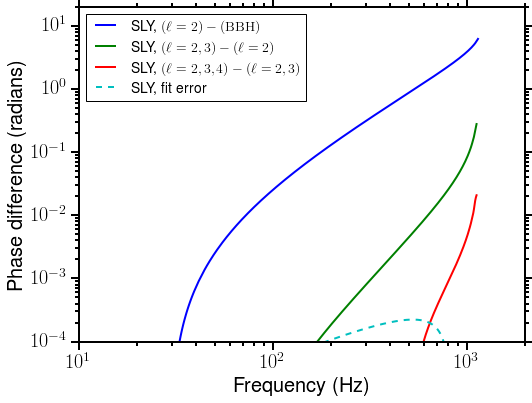

In [28]:
fig, axes = plt.subplots(1, figsize=(8, 6))

freq = bbh_ndr['freq'].numpy()

#phasediff = slyeffect.numpy()
#lenmin = min(len(freq), len(phasediff))
#axes.plot(freq[:lenmin], phasediff[:lenmin], lw=2, c='k', label=r'SLY, $(\ell=2,3,4)-({\rm BBH})$')

phasediff = sly2effect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=2, label=r'SLY, $(\ell=2)-({\rm BBH})$')

phasediff = sly3effect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=2, label=r'SLY, $(\ell=2,3)-(\ell=2)$')

phasediff = sly4effect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=2, label=r'SLY, $(\ell=2,3,4)-(\ell=2,3)$')

phasediff = slyfiteffect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=2, ls='--', label=r'SLY, fit error')

axes.set_xlim([10, 2000.0])
axes.set_ylim([1.0e-4, 20.0])
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlabel(r'Frequency (Hz)')
axes.set_ylabel(r'Phase difference (radians)')
axes.minorticks_on()
axes.legend(loc='upper left')

#fig.savefig('/home/bdlackey/public_html/ROM/slyphase.pdf', format='pdf', transparent=True, bbox_inches='tight')

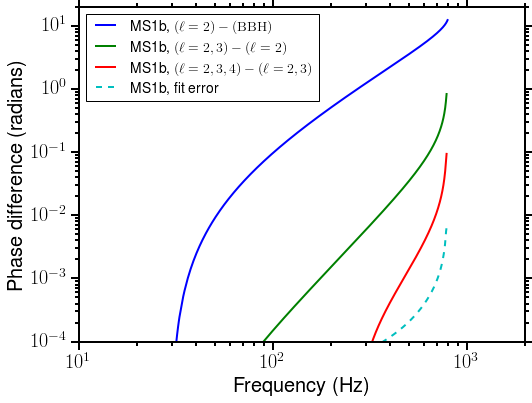

In [29]:
fig, axes = plt.subplots(1, figsize=(8, 6))

freq = bbh_ndr['freq'].numpy()

#phasediff = ms1beffect.numpy()
#lenmin = min(len(freq), len(phasediff))
#axes.plot(freq[:lenmin], phasediff[:lenmin], lw=2, c='k', label=r'MS1b, $(\ell=2,3,4)-({\rm BBH})$')

phasediff = ms1b2effect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=2, label=r'MS1b, $(\ell=2)-({\rm BBH})$')

phasediff = ms1b3effect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=2, label=r'MS1b, $(\ell=2,3)-(\ell=2)$')

phasediff = ms1b4effect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=2, label=r'MS1b, $(\ell=2,3,4)-(\ell=2,3)$')

phasediff = ms1bfiteffect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=2, ls='--', label=r'MS1b, fit error')

axes.set_xlim([10, 2000.0])
axes.set_ylim([1.0e-4, 20.0])
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlabel(r'Frequency (Hz)')
axes.set_ylabel(r'Phase difference (radians)')
axes.minorticks_on()
axes.legend(loc='upper left')

#fig.savefig('/home/bdlackey/public_html/ROM/ms1bphase.pdf', format='pdf', transparent=True, bbox_inches='tight')

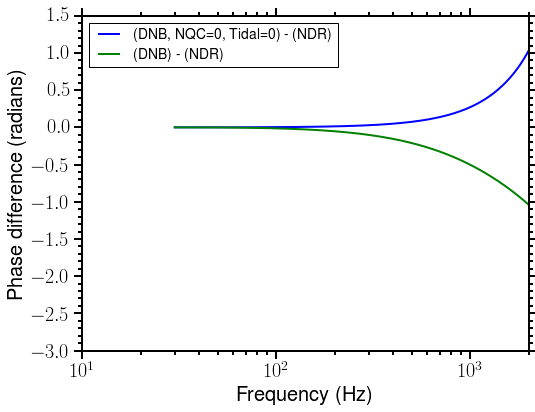

In [33]:
fig, axes = plt.subplots(1, figsize=(8, 6))

freq = bbh_ndr['freq'].numpy()

phasediff = nqc0effect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=2, label=r'(DNB, NQC=0, Tidal=0) - (NDR)')

phasediff = dnbeffect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=2, label=r'(DNB) - (NDR)')

axes.set_xlim([10, 2000.0])
#axes.set_ylim([1.0e-3, 20.0])
axes.set_xscale('log')
#axes.set_yscale('log')
axes.set_xlabel(r'Frequency (Hz)')
axes.set_ylabel(r'Phase difference (radians)')
axes.minorticks_on()
axes.legend(loc='upper left')

# Compare waveforms from pyCBC

In [34]:
pycbc.waveform.td_approximants()

['TaylorEt',
 'IMRPhenomA',
 'IMRPhenomC',
 'IMRPhenomB',
 'EOBNRv2',
 'PhenSpinTaylor',
 'PhenSpinTaylorRD',
 'NR_hdf5',
 'EOBNRv2HM',
 'SpinTaylorT4',
 'TaylorT1',
 'TaylorT3',
 'TaylorT2',
 'HGimri',
 'TaylorT4',
 'IMRPhenomD',
 'EccentricTD',
 'SEOBNRv1',
 'SpinDominatedWf',
 'SEOBNRv3',
 'SEOBNRv2',
 'SpinTaylorT1',
 'SpinTaylorT2',
 'SEOBNRv2_opt']

In [35]:
#approximant_list = ['EOBNRv2', 'SEOBNRv1', 'SEOBNRv2', 'SEOBNRv3', 'TaylorT1', 'TaylorT2', 'TaylorT3', 'TaylorT4']
# SEOBNRv2, v3 give the same waveform in the zero precession limit
approximant_list = ['EOBNRv2', 'SEOBNRv1', 'SEOBNRv2', 'TaylorT1', 'TaylorT2', 'TaylorT3', 'TaylorT4']

f_sample = 2**14
f_lower = 30

pycbc_waveform_list = []
for i in range(len(approximant_list)):
    print approximant_list[i]
    
    hp, hc = pycbc.waveform.get_td_waveform(approximant=approximant_list[i], mass1=1.35, mass2=1.35, 
                                          distance=100, delta_t=1.0/f_sample, f_lower=f_lower, f_ref=f_lower)
    
    hp.start_time, hc.start_time = 0.0, 0.0
    hcomplex = tsutils.polarizations_to_complex(hp, hc)
    amp, phase = tsutils.amp_phase_from_complex(hcomplex, remove_start_phase=True)
    freq = frequency_from_complex(hcomplex)
    pycbc_waveform_list.append({'label': approximant_list[i], 'hp': hp, 'hc': hc, 'amp': amp, 'phase': phase, 'freq': freq})

EOBNRv2
SEOBNRv1
SEOBNRv2
TaylorT1
TaylorT2
TaylorT3
TaylorT4


In [36]:
# difference in phase relative to Damour BBH EOB
Nwave = len(pycbc_waveform_list)
phase_diff_list = [phase_difference(pycbc_waveform_list[i]['hp'], pycbc_waveform_list[i]['hc'], 
                                    bbh_ndr['hp'], bbh_ndr['hc'], endpoint='maxamp') 
                   for i in range(Nwave)]

950556
950556 950554 950554
950556
950559 950554 950554
950556
950553 950554 950553
950488
950488 950554 950488
950533
950533 950554 950533
950485
950485 950554 950485
950530
950530 950554 950530


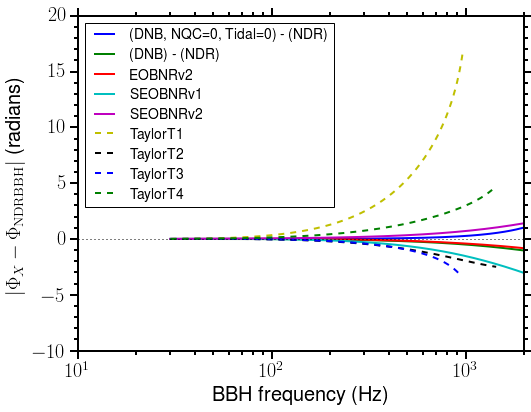

In [37]:
fig, axes = plt.subplots(1, figsize=(8, 6))


freq = bbh_ndr['freq'].numpy()

phasediff = nqc0effect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=2, label=r'(DNB, NQC=0, Tidal=0) - (NDR)')

phasediff = dnbeffect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=2, label=r'(DNB) - (NDR)')


ls_list = ['-', '-', '-', '--', '--', '--', '--']

for i in range(Nwave):
    phasediff = np.array(phase_diff_list[i].numpy())
    lenmin = min(len(freq), len(phasediff))
    axes.plot(freq[:lenmin], phasediff[:lenmin], lw=2, ls=ls_list[i], label=approximant_list[i])

axes.axhline(0, color='k', ls=':')

axes.set_xlim([10, 2000.0])
#axes.set_ylim([1.0e-3, 20.0])
axes.set_xscale('log')
#axes.set_yscale('log')
axes.set_xlabel(r'BBH frequency (Hz)')
axes.set_ylabel(r'$|\Phi_X - \Phi_{\rm NDR BBH}|$ (radians)')
axes.minorticks_on()
axes.legend(loc='upper left')

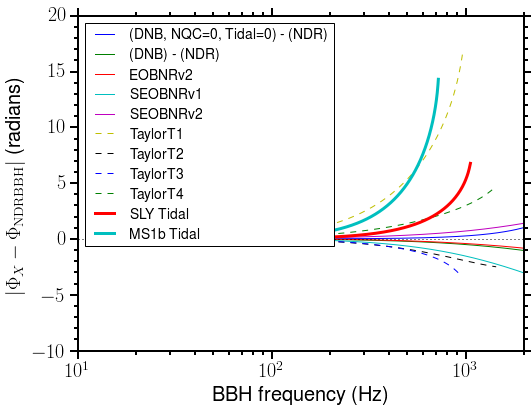

In [38]:
fig, axes = plt.subplots(1, figsize=(8, 6))


freq = bbh_ndr['freq'].numpy()

phasediff = nqc0effect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=1, label=r'(DNB, NQC=0, Tidal=0) - (NDR)')

phasediff = dnbeffect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=1, label=r'(DNB) - (NDR)')


ls_list = ['-', '-', '-', '--', '--', '--', '--']

for i in range(Nwave):
    phasediff = np.array(phase_diff_list[i].numpy())
    lenmin = min(len(freq), len(phasediff))
    axes.plot(freq[:lenmin], phasediff[:lenmin], lw=1, ls=ls_list[i], label=approximant_list[i])

phasediff = slyeffect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=3, ls='-', label='SLY Tidal')

phasediff = ms1beffect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=3, ls='-', label='MS1b Tidal')


axes.axhline(0, color='k', ls=':')

axes.set_xlim([10, 2000.0])
#axes.set_ylim([1.0e-3, 20.0])
axes.set_xscale('log')
#axes.set_yscale('log')
axes.set_xlabel(r'BBH frequency (Hz)')
axes.set_ylabel(r'$|\Phi_X - \Phi_{\rm NDR BBH}|$ (radians)')
axes.minorticks_on()
axes.legend(loc='upper left')

In [39]:
freq = bbh_ndr['freq'].numpy()
eoblenmin = np.min((len(freq), len(nqc0effect), len(dnbeffect), 
                 len(phase_diff_list[0]), len(phase_diff_list[1]), len(phase_diff_list[2])
                ))

eobmin = np.array([
        np.min((nqc0effect[i], dnbeffect[i], phase_diff_list[0][i], phase_diff_list[1][i], phase_diff_list[2][i]))
               for i in range(0, eoblenmin, 5)])

eobmax = np.array([
        np.max((nqc0effect[i], dnbeffect[i], phase_diff_list[0][i], phase_diff_list[1][i], phase_diff_list[2][i]))
               for i in range(0, eoblenmin, 5)])


In [40]:
freq = bbh_ndr['freq'].numpy()
pnlenmin = np.min((len(freq), len(nqc0effect), len(dnbeffect), 
                 len(phase_diff_list[3]), len(phase_diff_list[4]), len(phase_diff_list[5]), len(phase_diff_list[6])
                ))

pnmin = np.array([np.min((phase_diff_list[3][i], phase_diff_list[4][i], phase_diff_list[5][i], phase_diff_list[6][i]))
               for i in range(0, pnlenmin, 5)])

pnmax = np.array([np.max((phase_diff_list[3][i], phase_diff_list[4][i], phase_diff_list[5][i], phase_diff_list[6][i]))
               for i in range(0, pnlenmin, 5)])


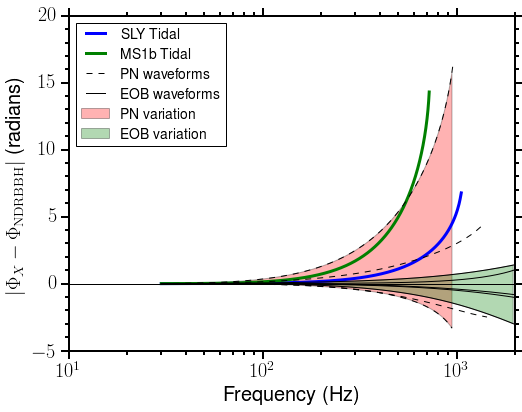

In [43]:
fig, axes = plt.subplots(1, figsize=(8, 6))

axes.fill_between(freq[0:pnlenmin:5], pnmin, pnmax, facecolor='red', alpha=0.3, label='PN variation')
axes.fill_between(freq[0:eoblenmin:5], eobmin, eobmax, facecolor='green', alpha=0.3, label='EOB variation')


phasediff = slyeffect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=3, ls='-', label='SLY Tidal')

phasediff = ms1beffect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=3, ls='-', label='MS1b Tidal')


########################
freq = bbh_ndr['freq'].numpy()

phasediff = nqc0effect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=1, c='k')

phasediff = dnbeffect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=1, c='k')


ls_list = ['-', '-', '-', '--', '--', '--', '--']

for i in range(Nwave):
    phasediff = np.array(phase_diff_list[i].numpy())
    lenmin = min(len(freq), len(phasediff))
    axes.plot(freq[:lenmin], phasediff[:lenmin], lw=1, c='k', ls=ls_list[i])
###########################

axes.axhline(-10, lw=1, c='k', ls='--', label='PN waveforms')
axes.axhline(-10, lw=1, c='k', ls='-', label='EOB waveforms')

axes.axhline(0, lw=1, color='k', ls='-')

axes.set_xlim([10, 2000])
axes.set_ylim([-5, 20])
axes.set_xscale('log')
#axes.set_yscale('log')
axes.set_xlabel(r'Frequency (Hz)')
axes.set_ylabel(r'$|\Phi_X - \Phi_{\rm NDR BBH}|$ (radians)')
axes.minorticks_on()
axes.legend(loc='upper left')

fig.savefig('/home/bdlackey/public_html/ROM/pnvseobphase.pdf', format='pdf', transparent=True, bbox_inches='tight')

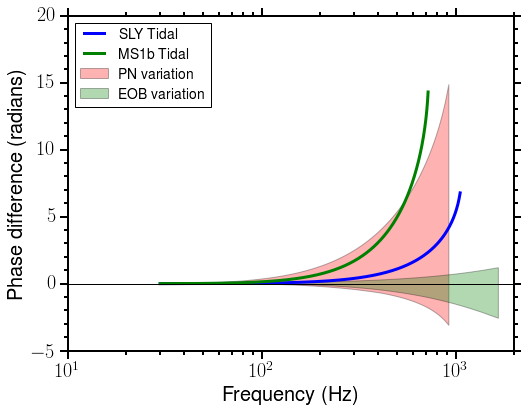

In [28]:
fig, axes = plt.subplots(1, figsize=(8, 6))

axes.fill_between(freq[0:pnlenmin:10], pnmin, pnmax, facecolor='red', alpha=0.3, label='PN variation')
axes.fill_between(freq[0:eoblenmin:10], eobmin, eobmax, facecolor='green', alpha=0.3, label='EOB variation')


phasediff = slyeffect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=3, ls='-', label='SLY Tidal')

phasediff = ms1beffect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=3, ls='-', label='MS1b Tidal')



axes.axhline(0, lw=1, color='k', ls='-')

axes.set_xlim([10, 2000])
axes.set_ylim([-5, 20])
axes.set_xscale('log')
#axes.set_yscale('log')
axes.set_xlabel(r'Frequency (Hz)')
axes.set_ylabel(r'Phase difference (radians)')
#axes.set_ylabel(r'$|\Phi_X - \Phi_{\rm NDR BBH}|$ (radians)')
axes.minorticks_on()
axes.legend(loc='upper left')

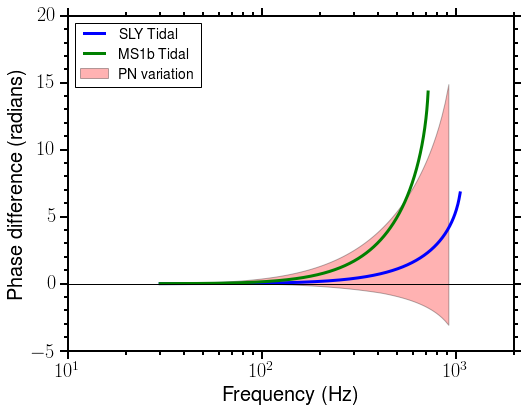

In [29]:
fig, axes = plt.subplots(1, figsize=(8, 6))

axes.fill_between(freq[0:pnlenmin:10], pnmin, pnmax, facecolor='red', alpha=0.3, label='PN variation')


phasediff = slyeffect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=3, ls='-', label='SLY Tidal')

phasediff = ms1beffect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=3, ls='-', label='MS1b Tidal')



axes.axhline(0, lw=1, color='k', ls='-')

axes.set_xlim([10, 2000])
axes.set_ylim([-5, 20])
axes.set_xscale('log')
#axes.set_yscale('log')
axes.set_xlabel(r'Frequency (Hz)')
axes.set_ylabel(r'Phase difference (radians)')
#axes.set_ylabel(r'$|\Phi_X - \Phi_{\rm NDR BBH}|$ (radians)')
axes.minorticks_on()
axes.legend(loc='upper left')

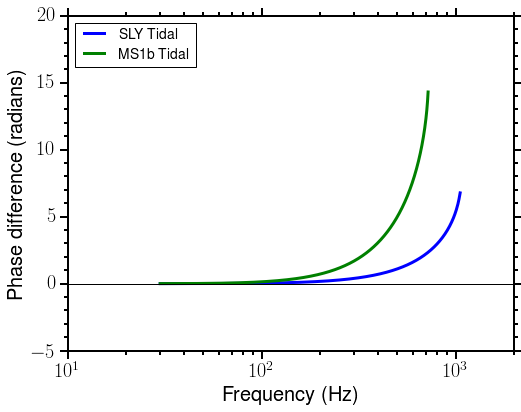

In [30]:
fig, axes = plt.subplots(1, figsize=(8, 6))



phasediff = slyeffect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=3, ls='-', label='SLY Tidal')

phasediff = ms1beffect.numpy()
lenmin = min(len(freq), len(phasediff))
axes.plot(freq[:lenmin], phasediff[:lenmin], lw=3, ls='-', label='MS1b Tidal')



axes.axhline(0, lw=1, color='k', ls='-')

axes.set_xlim([10, 2000])
axes.set_ylim([-5, 20])
axes.set_xscale('log')
#axes.set_yscale('log')
axes.set_xlabel(r'Frequency (Hz)')
axes.set_ylabel(r'Phase difference (radians)')
#axes.set_ylabel(r'$|\Phi_X - \Phi_{\rm NDR BBH}|$ (radians)')
axes.minorticks_on()
axes.legend(loc='upper left')